## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'pastis-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_diagonal_wavelet_full_pastis.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/pastis/full/wavelet/diagonal/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 1590, 3: 6360, 4: 25440, 5: 101760, 6: 407040, 7: 1628160, 8: 6512640}

Running 12760 CDFs


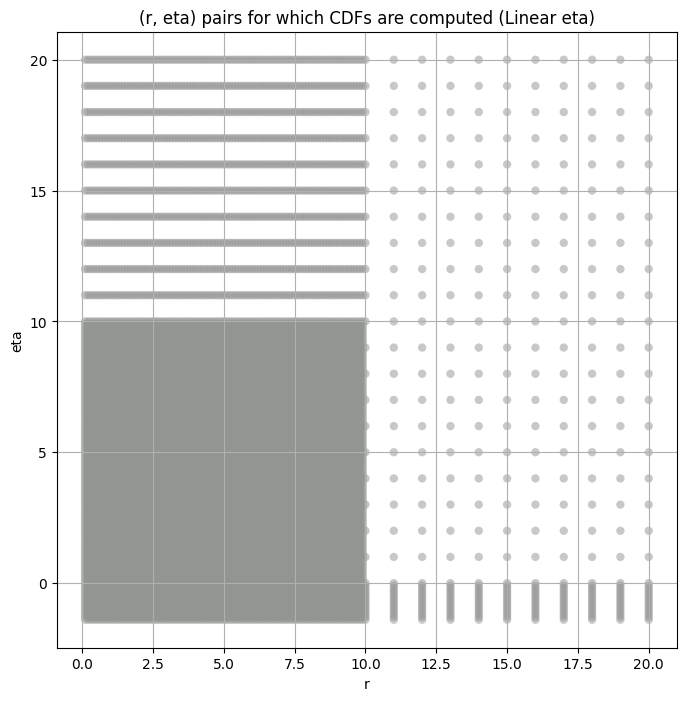

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      995.566040  864.354500  1142.784500   2.687830    1.028233    4.575933   
3      299.988920  279.984800   320.884950   2.454340    1.804920    3.180163   
4       75.562880   71.306270    80.026050   2.987251    2.351555    3.896905   
5       14.565750   13.678300    15.491117   3.872311    3.021069    4.954880   
6        2.581126    2.403492     2.771678   5.708778    4.301481    8.222433   
7        0.439725    0.403006     0.480876   9.534605    6.583607   17.606100   
8        0.044586    0.040037     0.050722  18.418106    8.617492   67.336680   

       total_samples  
layer                 
2               1590  
3               6360  
4              25440  
5             101760  
6             407040  
7            1628160  
8            6512640

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                              
2      995.566040     995.566040      717.931519      592.038452   
3      299.988920     299.988922      262.291290      241.907791   
4       75.562880      75.562881       71.876602       69.405899   
5       14.565750      14.565750       14.268504       14.059965   
6        2.581126       2.581126        2.513133        2.469111   
7        0.439725       0.439725        0.423542        0.413688   
8        0.044586       0.044586        0.042118        0.040888   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2          501.997223       431.631104       331.800354       255.913284   
3          226.815094       213.982346       192.787399       174.900665   
4           67.308624        65.531357        62.497429        59.930573   
5           13.883931        13.725800        13.447207        13.201767   
6            2.431959         2.399192         2.341324         2.290699   
7            0.405621         0.398581         0.386425         0.376005   
8            0.039910         0.039075         0.037666         0.036484   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2           197.254913       151.263138       113.571434        45.821770  
3           159.995728       147.078751       135.796860       108.415482  
4            57.695976        55.682301        53.822483        49.090103  
5            12.980224        12.773644        12.582219        12.069887  
6             2.245248         2.203666         2.165223         2.063956  
7             0.366785         0.358422         0.350759         0.330786  
8             0.035453         0.034532         0.033697         0.031561

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.012170273372231089 995.56604


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.023664349560852393 717.9315


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.03979524681852617 592.03845


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.05537863625616157 501.99722


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.07329858959931124 431.6311


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.10313871885165138 331.80035


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.12974188360807282 255.91328


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.15393355899163585 197.25491


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.17666391707157514 151.26314


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.20305305887260205 113.571434


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.2799555982538606 45.82177
Number of samples: 1590, Without approximation : 1590


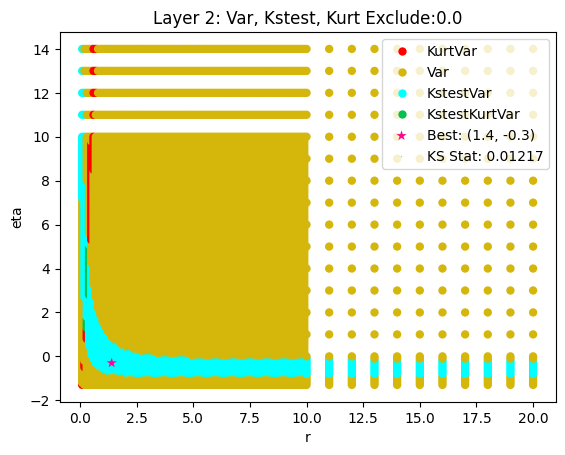

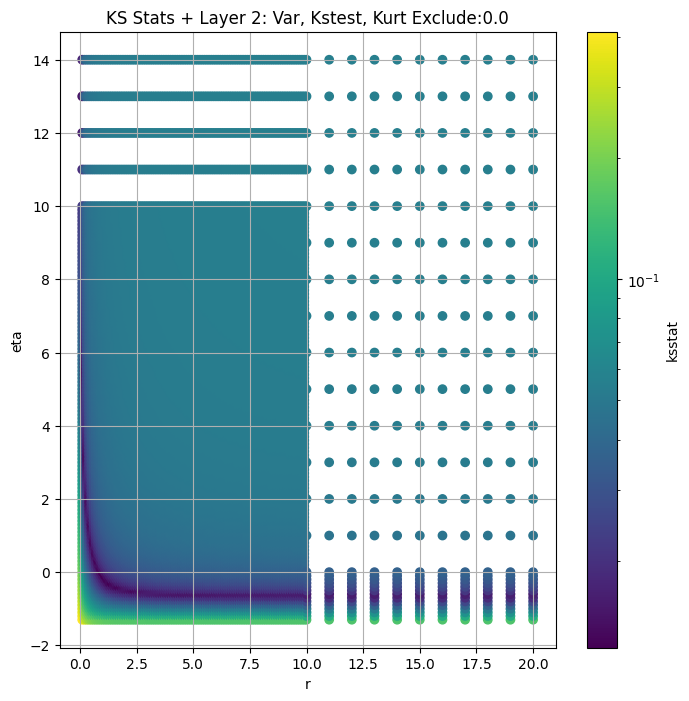

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.008432238552253446 299.98892


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.010586749995223799 262.2913


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.015138021672389299 241.90779


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.02044877272246498 226.8151


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.025324665362590114 213.98235


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.03363327409994687 192.7874


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.04108526909653255 174.90067


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.04828929818507084 159.99573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.055424881389836034 147.07875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.06232758578617824 135.79686


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.08320619085021438 108.41548
Number of samples: 6360, Without approximation : 6360


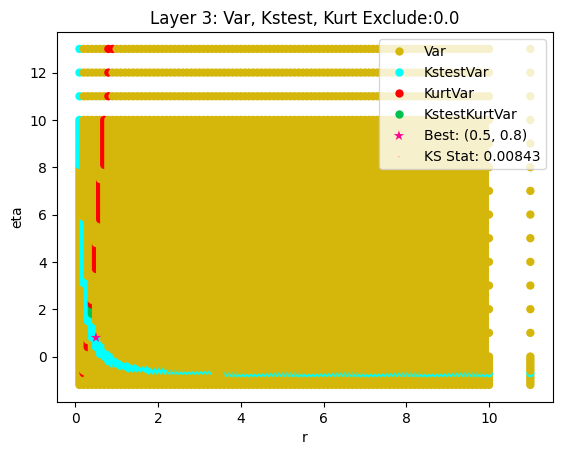

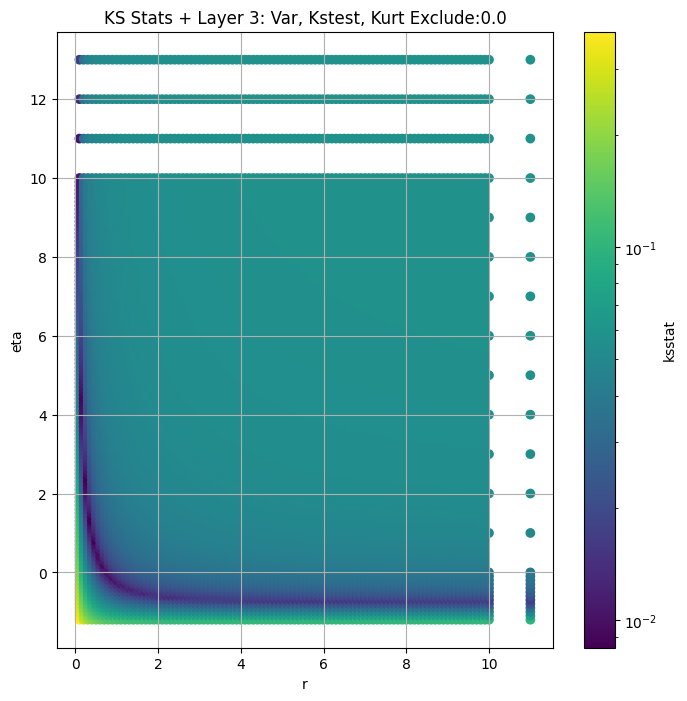

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.0028530694424134806 75.56288


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.003788187848982605 71.8766


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.00496999694530853 69.4059


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.006012141564691098 67.308624


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.006942802364037992 65.53136


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.008817590441093183 62.49743


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.010455889468649171 59.930573


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.012759125053066644 57.695976


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.015131480798590134 55.6823


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.017088557058077443 53.822483


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.02404141135407778 49.090103
Number of samples: 25440, Without approximation : 25440


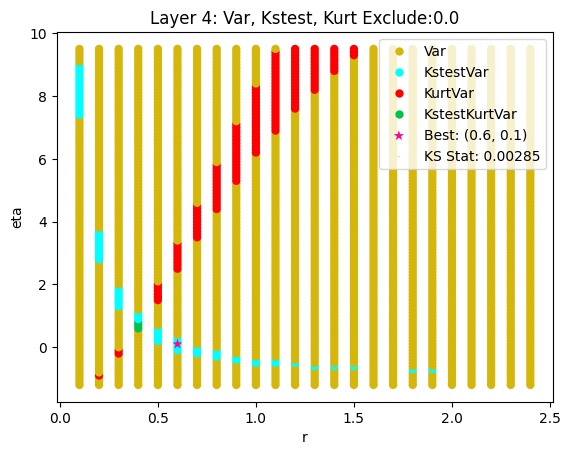

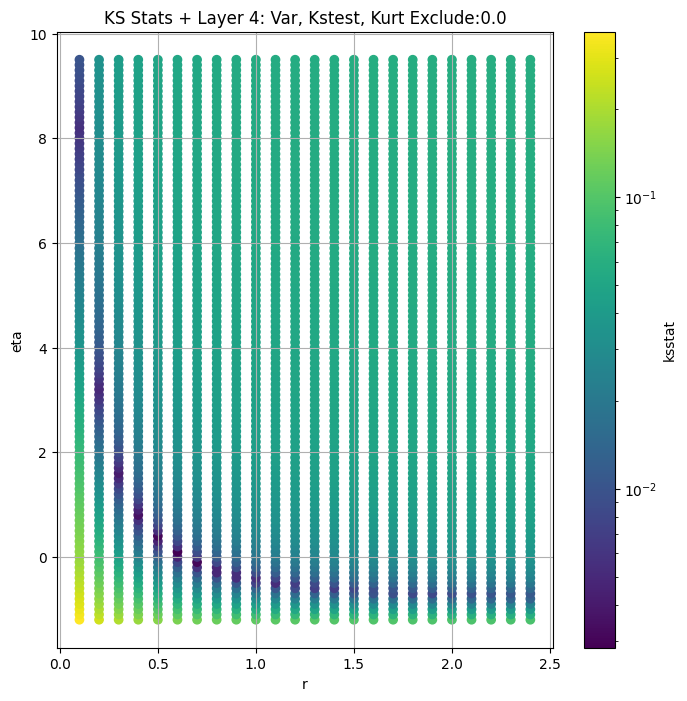

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.002758680605561614 14.56575


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.002842937967462267 14.268504


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.002603343901223687 14.059965


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.0031363370845138017 13.883931


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.003292596202097653 13.7258


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.0036690204651543268 13.447207


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.004305819937567956 13.201767


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.004959663387604785 12.980224


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.005634479959645278 12.773644


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.006170814387861934 12.582219


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.007685140881986241 12.069887
Number of samples: 100000, Without approximation : 101760


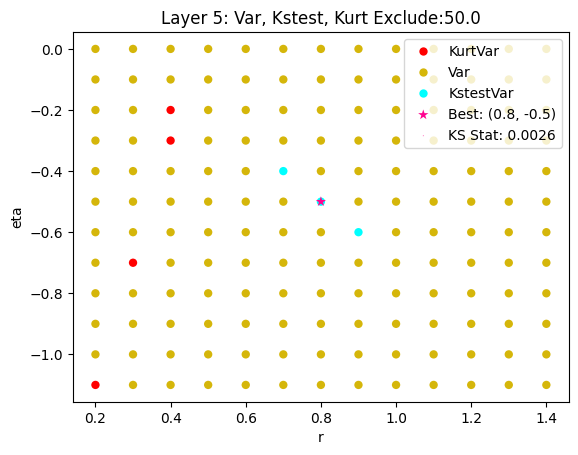

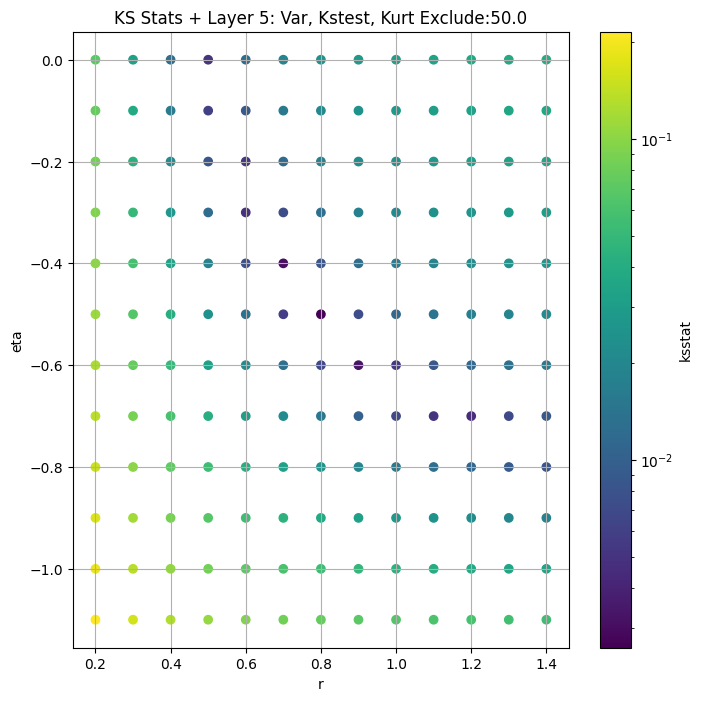

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.004480240031108085 2.5811265


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.004150897949233401 2.513133


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.004969611223914594 2.4691107


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.0043120903204202365 2.431959


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.0050856530914749065 2.3991916


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.006317909660572885 2.341324


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.00610000070941219 2.2906988


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.006484644388891236 2.2452478


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.006846280254740933 2.2036664


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.007177193743067689 2.1652231


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.008472216439738944 2.063956
Number of samples: 100000, Without approximation : 407040


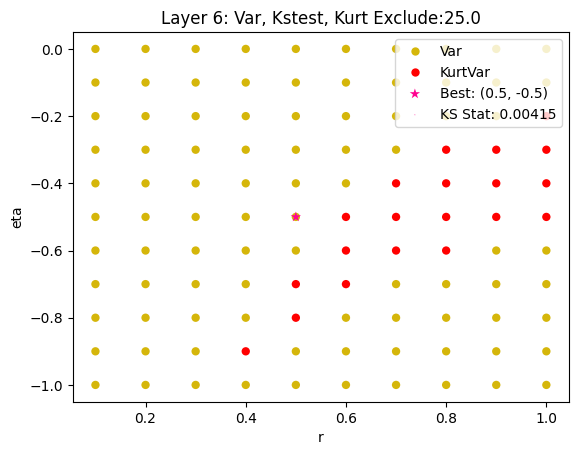

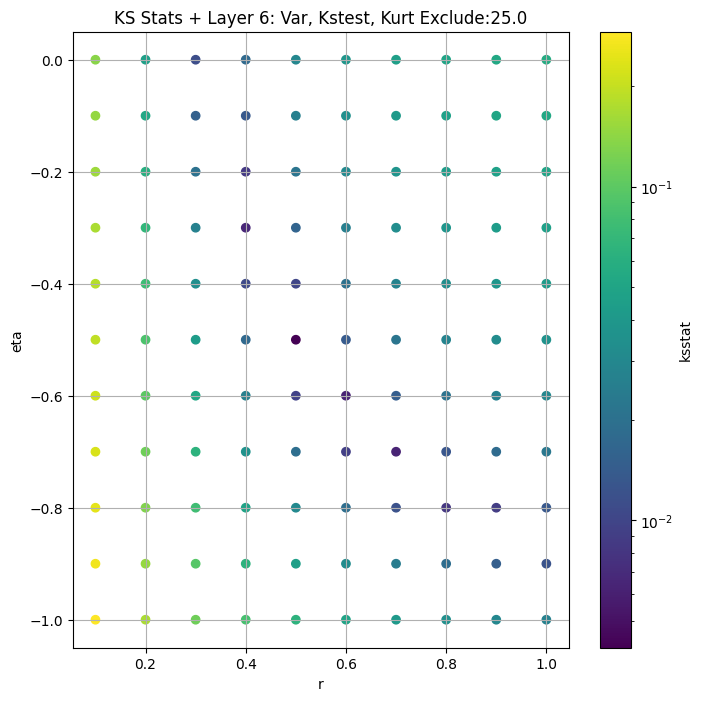

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.00653277775518224 0.43972453


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.005992491664784549 0.423542


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.007289627879929816 0.41368794


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.007863441220176903 0.40562105


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.0068381450780896635 0.39858064


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.007236133968193892 0.38642478


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.007937861501053467 0.37600496


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.008698136929677358 0.36678526


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.008837876650612864 0.35842198


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.008418542382632732 0.3507592


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.009573963746865699 0.33078596
Number of samples: 100000, Without approximation : 1628160


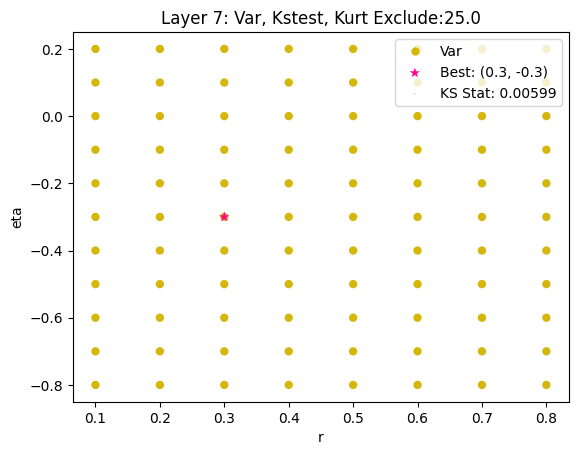

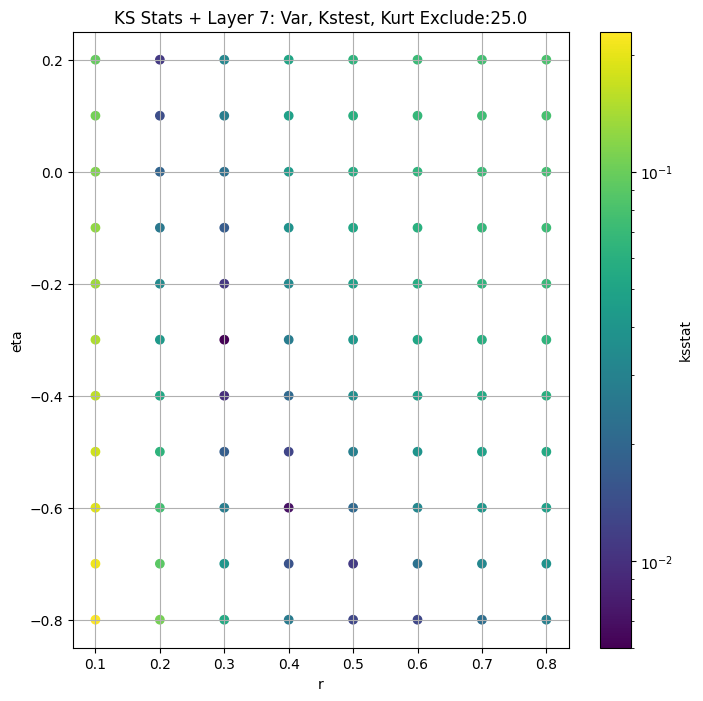

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.004613220285520414 0.04458634


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.004921681940721956 0.042118374


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.005638260698206887 0.04088767


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.006025940219449577 0.039910316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.005429553045853797 0.03907463


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0064632940600259925 0.037665877


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.006407756842812917 0.036484458


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.0071835769495847135 0.035453185


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.007396011811728553 0.03453249


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.00836890867375295 0.033696827


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.009913534505811672 0.031560853
Number of samples: 100000, Without approximation : 6512640


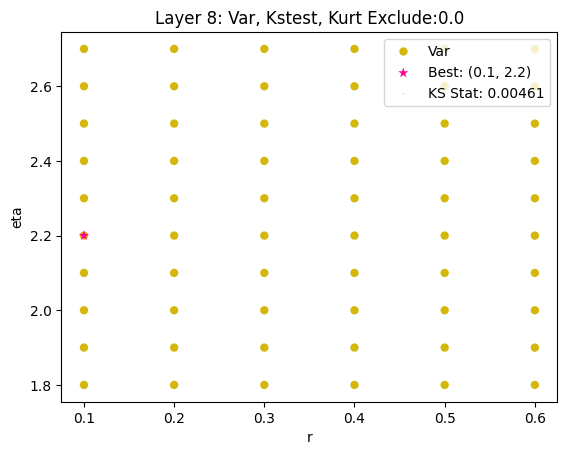

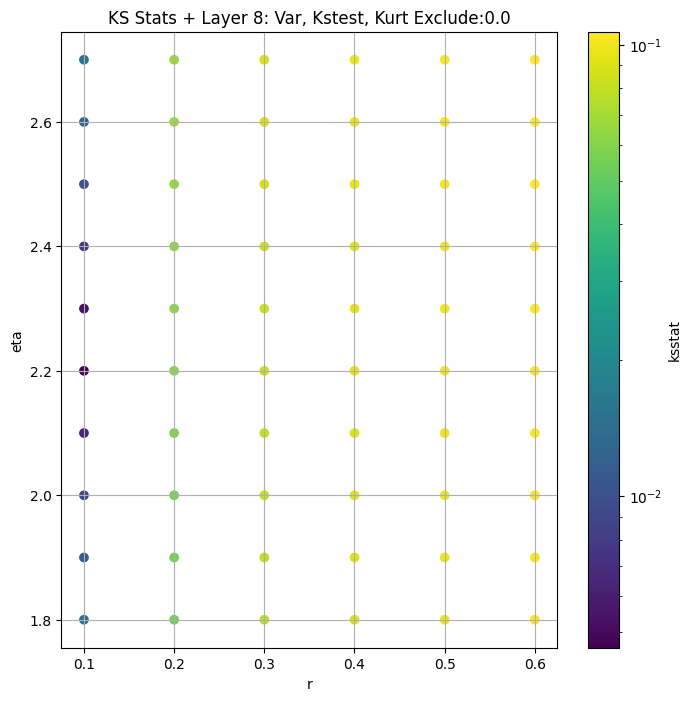

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      995.566040  864.354500  1142.784500   2.687830    1.028233    4.575933   
3      299.988920  279.984800   320.884950   2.454340    1.804920    3.180163   
4       75.562880   71.306270    80.026050   2.987251    2.351555    3.896905   
5       14.565750   13.678300    15.491117   3.872311    3.021069    4.954880   
6        2.581126    2.403492     2.771678   5.708778    4.301481    8.222433   
7        0.439725    0.403006     0.480876   9.534605    6.583607   17.606100   
8        0.044586    0.040037     0.050722  18.418106    8.617492   67.336680   

       total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                               
2               1590             0.012170        1.4         -0.3   
3               6360             0.008432        0.5          0.8   
4              25440             0.002853        0.6          0.1   
5             101760             0.002603        0.8         -0.5   
6             407040             0.004151        0.5         -0.5   
7            1628160             0.005992        0.3         -0.3   
8            6512640             0.004613        0.1          2.2   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       1.236068e+03                     0.0          995.566040   
3       1.164553e+01                     0.0          299.988920   
4       1.227684e+01                     0.0           75.562880   
5       9.586700e+00                    50.0           14.059965   
6       4.188555e-01                    25.0            2.513133   
7       1.874817e-03                    25.0            0.423542   
8       3.014167e-18                     0.0            0.044586   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.033952  
3                     0.017003  
4                     0.008508  
5                     0.004256  
6                     0.002128  
7                     0.001064  
8                     0.000532

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 100 = 100, ksstat: 0.0859794579211487, var: 431.631103515625


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 75 = 75, ksstat: 0.07095608885498361, var: 501.9972229003906


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 50 = 50, ksstat: 0.05399972214197779, var: 592.0384521484375


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 25 = 25, ksstat: 0.033724333818647034, var: 717.9315185546875


  0%|          | 0/1620 [00:00<?, ?it/s]

Finding Minimum after computing 1620 CDFs
layer 2, 0.0 + 0 = 0, ksstat: 0.011978663064072637, var: 995.5660400390625
Number of samples: 1590, Without approximation : 1590


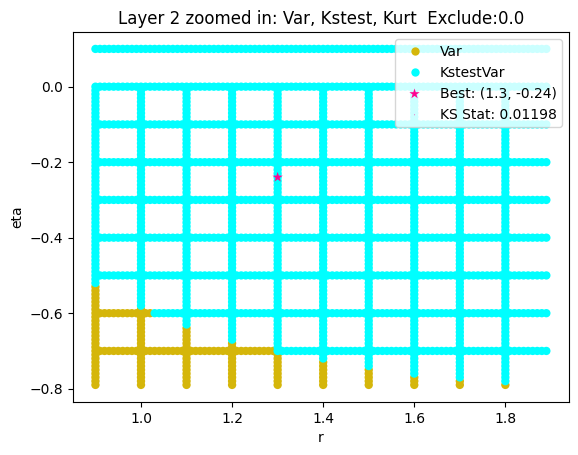

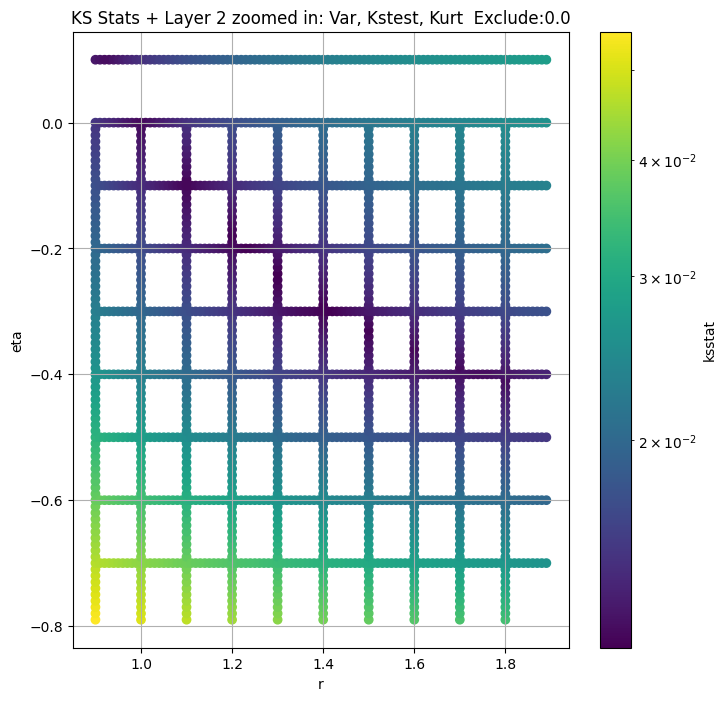

Layer 3


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.028241044512422583, var: 213.9823455810547


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.02366524140907003, var: 226.81509399414062


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.01840879859674098, var: 241.9077911376953


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.012851312508053492, var: 262.2912902832031


  0%|          | 0/882 [00:00<?, ?it/s]

Finding Minimum after computing 882 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.008148137641604603, var: 299.9889221191406
Number of samples: 6360, Without approximation : 6360


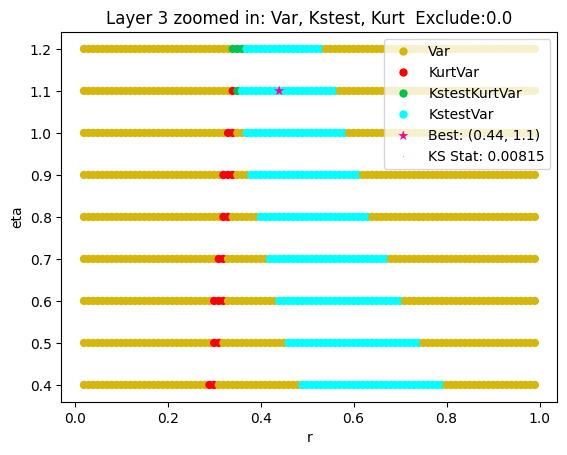

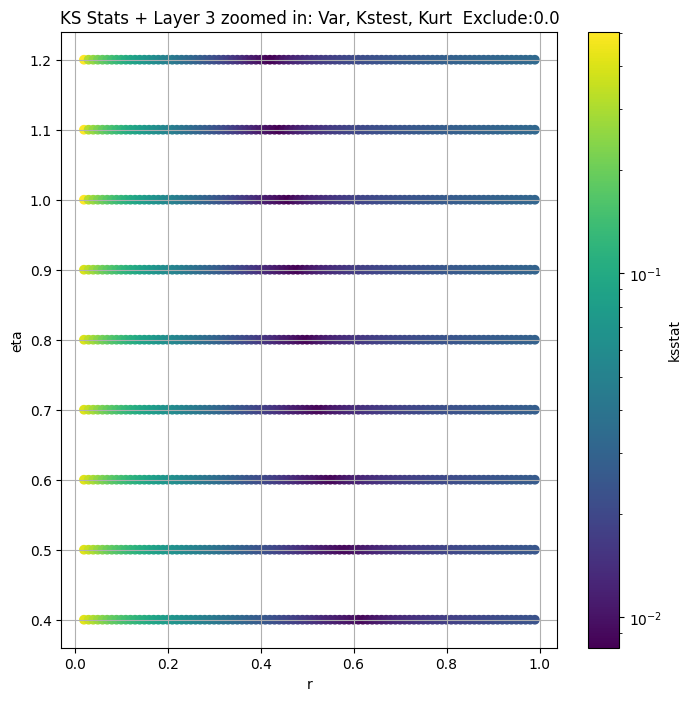

Layer 4


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 100 = 100, ksstat: 0.0074760702671603785, var: 65.53135681152344


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 75 = 75, ksstat: 0.006040491084571498, var: 67.30862426757812


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 50 = 50, ksstat: 0.004866213245236062, var: 69.40589904785156


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 25 = 25, ksstat: 0.0036786109883661933, var: 71.87660217285156


  0%|          | 0/1215 [00:00<?, ?it/s]

Finding Minimum after computing 1215 CDFs
layer 4, 0.0 + 0 = 0, ksstat: 0.0027433526539583086, var: 75.56288146972656
Number of samples: 25440, Without approximation : 25440


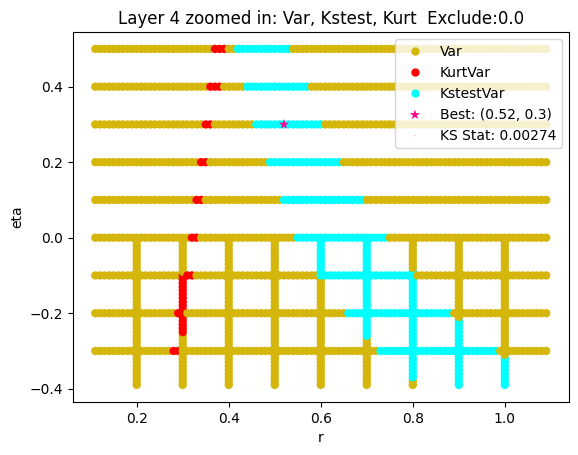

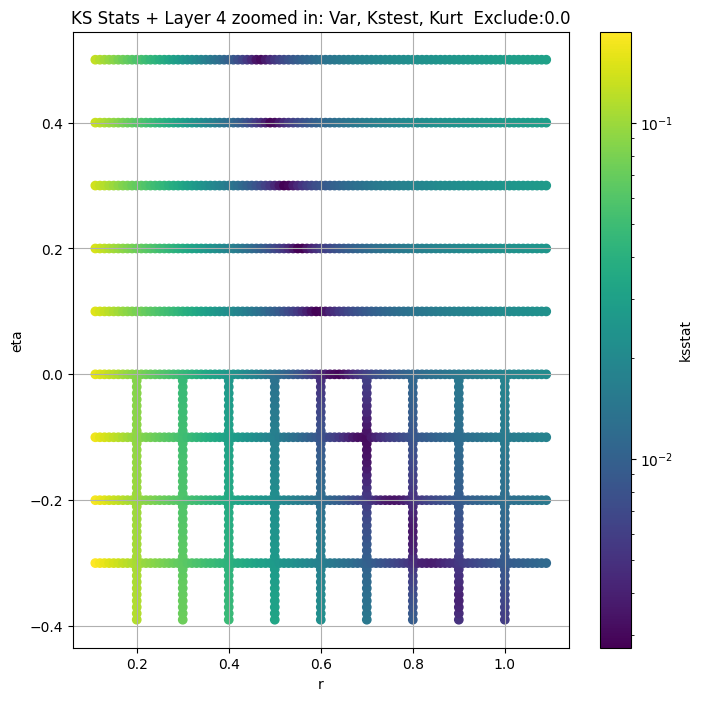

Layer 5


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + 100 = 150, ksstat: 0.0036669353508943514, var: 13.4472074508667


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + 75 = 125, ksstat: 0.003304649285767791, var: 13.581552505493164


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + 50 = 100, ksstat: 0.002957308530109115, var: 13.725799560546875


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + 25 = 75, ksstat: 0.002590816840003729, var: 13.883931159973145


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + 0 = 50, ksstat: 0.0023471092494263823, var: 14.059965133666992


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + -25 = 25, ksstat: 0.0020427353364778217, var: 14.26850414276123


  0%|          | 0/1701 [00:00<?, ?it/s]

Finding Minimum after computing 1701 CDFs
layer 5, 50.0 + -50 = 0, ksstat: 0.001753397058808337, var: 14.565750122070312
Number of samples: 100000, Without approximation : 101760


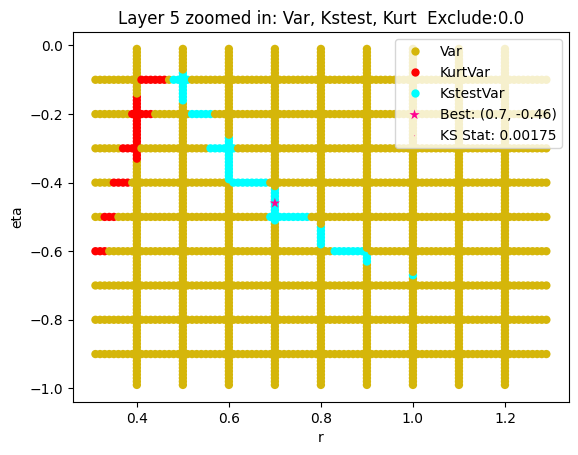

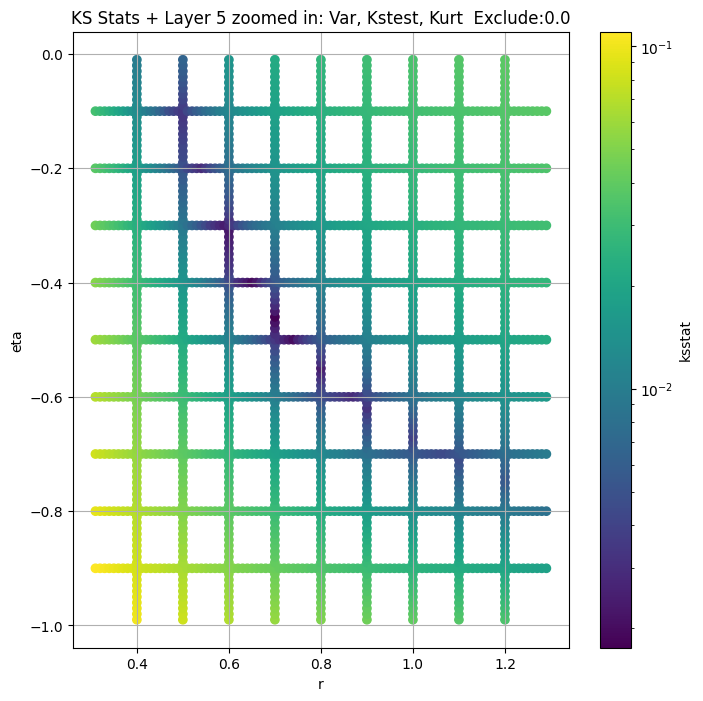

Layer 6


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + 100 = 125, ksstat: 0.004694013671022512, var: 2.369234085083008


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + 75 = 100, ksstat: 0.004804114850495977, var: 2.3991916179656982


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + 50 = 75, ksstat: 0.0043120903204202365, var: 2.4319589138031006


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + 25 = 50, ksstat: 0.004259331184461146, var: 2.4691107273101807


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + 0 = 25, ksstat: 0.004071632984090745, var: 2.5131330490112305


  0%|          | 0/1692 [00:00<?, ?it/s]

Finding Minimum after computing 1692 CDFs
layer 6, 25.0 + -25 = 0, ksstat: 0.0038645105893608256, var: 2.5811264514923096
Number of samples: 100000, Without approximation : 407040


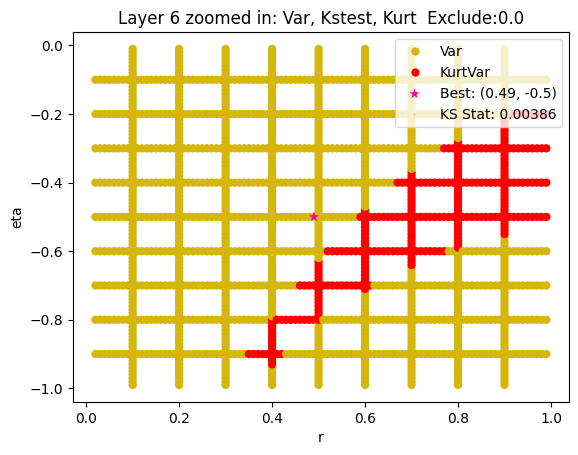

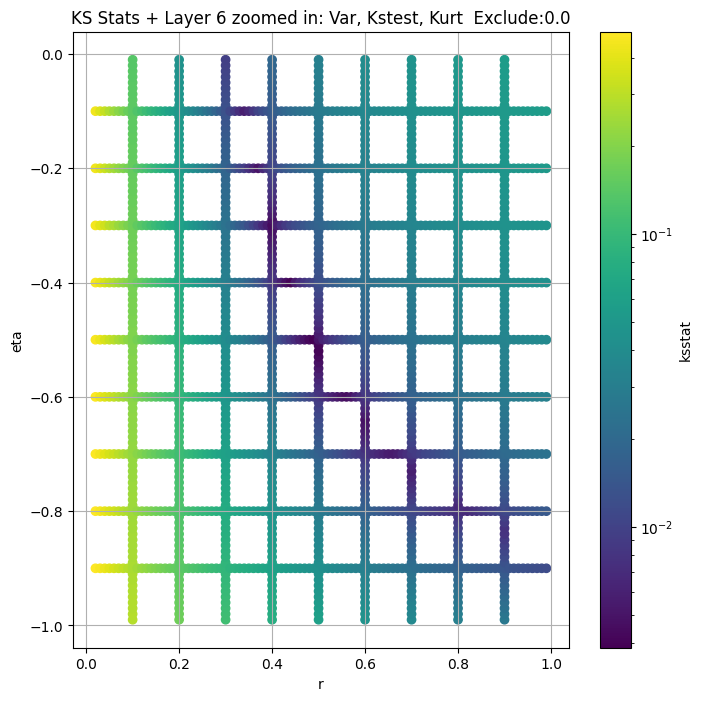

Layer 7


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + 100 = 125, ksstat: 0.006196734595591891, var: 0.3922286927700043


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + 75 = 100, ksstat: 0.0057719437928825945, var: 0.3985806405544281


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + 50 = 75, ksstat: 0.005489209275417961, var: 0.4056210517883301


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + 25 = 50, ksstat: 0.005285288172331093, var: 0.41368794441223145


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + 0 = 25, ksstat: 0.005129187888257558, var: 0.42354199290275574


  0%|          | 0/1206 [00:00<?, ?it/s]

Finding Minimum after computing 1206 CDFs
layer 7, 25.0 + -25 = 0, ksstat: 0.004638496532249681, var: 0.43972453474998474
Number of samples: 100000, Without approximation : 1628160


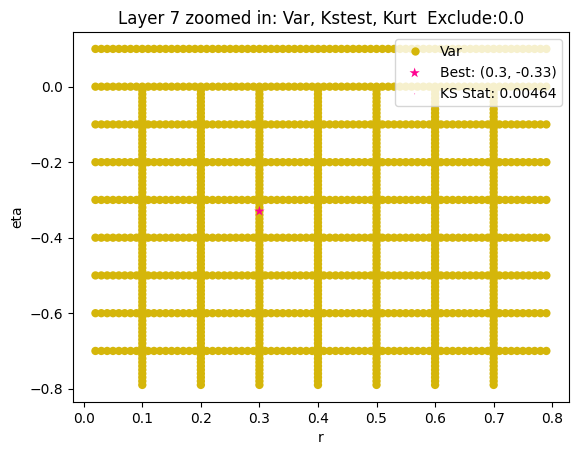

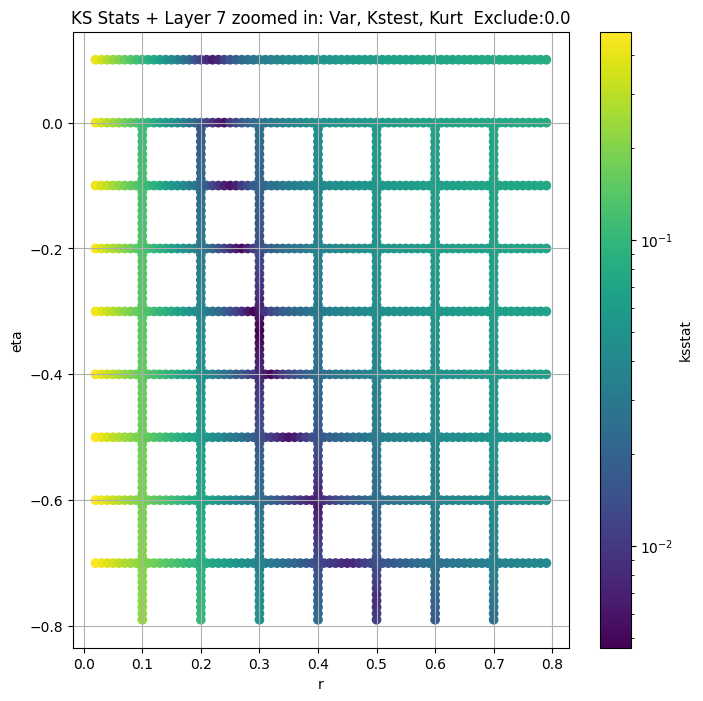

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 100 = 100, ksstat: 0.006468126192501367, var: 0.03907462954521179


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 75 = 75, ksstat: 0.005964769484944177, var: 0.039910316467285156


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 50 = 50, ksstat: 0.005374847926266746, var: 0.04088766872882843


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 25 = 25, ksstat: 0.004853145847886209, var: 0.0421183742582798


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 0.0 + 0 = 0, ksstat: 0.00446427932132254, var: 0.044586341828107834
Number of samples: 100000, Without approximation : 6512640


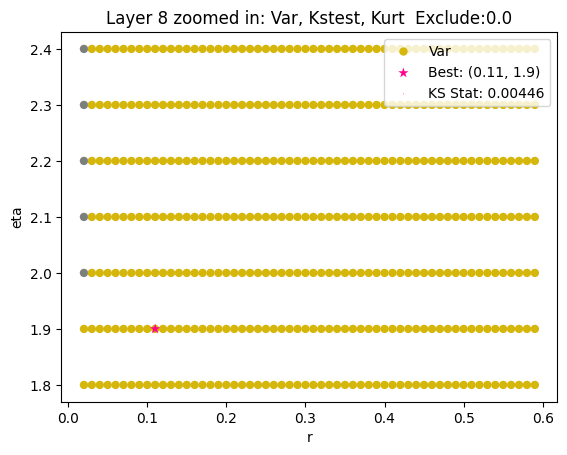

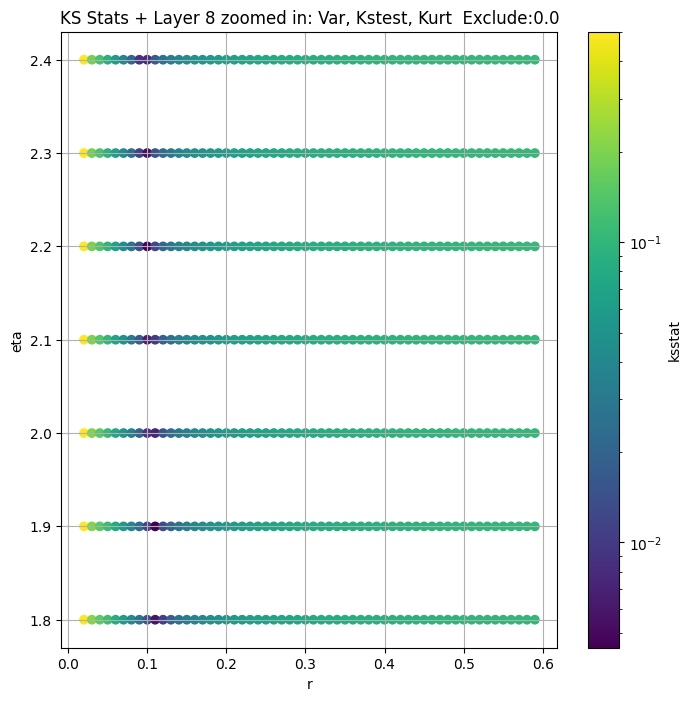

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      995.566040  864.354500  1142.784500   2.687830    1.028233    4.575933   
3      299.988920  279.984800   320.884950   2.454340    1.804920    3.180163   
4       75.562880   71.306270    80.026050   2.987251    2.351555    3.896905   
5       14.565750   13.678300    15.491117   3.872311    3.021069    4.954880   
6        2.581126    2.403492     2.771678   5.708778    4.301481    8.222433   
7        0.439725    0.403006     0.480876   9.534605    6.583607   17.606100   
8        0.044586    0.040037     0.050722  18.418106    8.617492   67.336680   

       total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                               
2               1590             0.012170        1.4         -0.3   
3               6360             0.008432        0.5          0.8   
4              25440             0.002853        0.6          0.1   
5             101760             0.002603        0.8         -0.5   
6             407040             0.004151        0.5         -0.5   
7            1628160             0.005992        0.3         -0.3   
8            6512640             0.004613        0.1          2.2   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       1.236068e+03                     0.0          995.566040   
3       1.164553e+01                     0.0          299.988922   
4       1.227684e+01                     0.0           75.562881   
5       9.586700e+00                    50.0           14.565750   
6       4.188555e-01                    25.0            2.581126   
7       1.874817e-03                    25.0            0.439725   
8       3.014167e-18                     0.0            0.044586   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.033952          0.011979    1.30     -0.24   
3                     0.017003          0.008148    0.44      1.10   
4                     0.008508          0.002743    0.52      0.30   
5                     0.004256          0.001753    0.70     -0.46   
6                     0.002128          0.003865    0.49     -0.50   
7                     0.001064          0.004638    0.30     -0.33   
8                     0.000532          0.004464    0.11      1.90   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      1.106623e+03                  0.0        13578  
3      4.233649e+00                  0.0        27165  
4      5.531722e+00                  0.0       244498  
5      6.972310e+00                  0.0       579555  
6      3.948604e-01                  0.0       128790  
7      2.082072e-03                  0.0        85860  
8      4.250085e-16                  0.0        96592

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

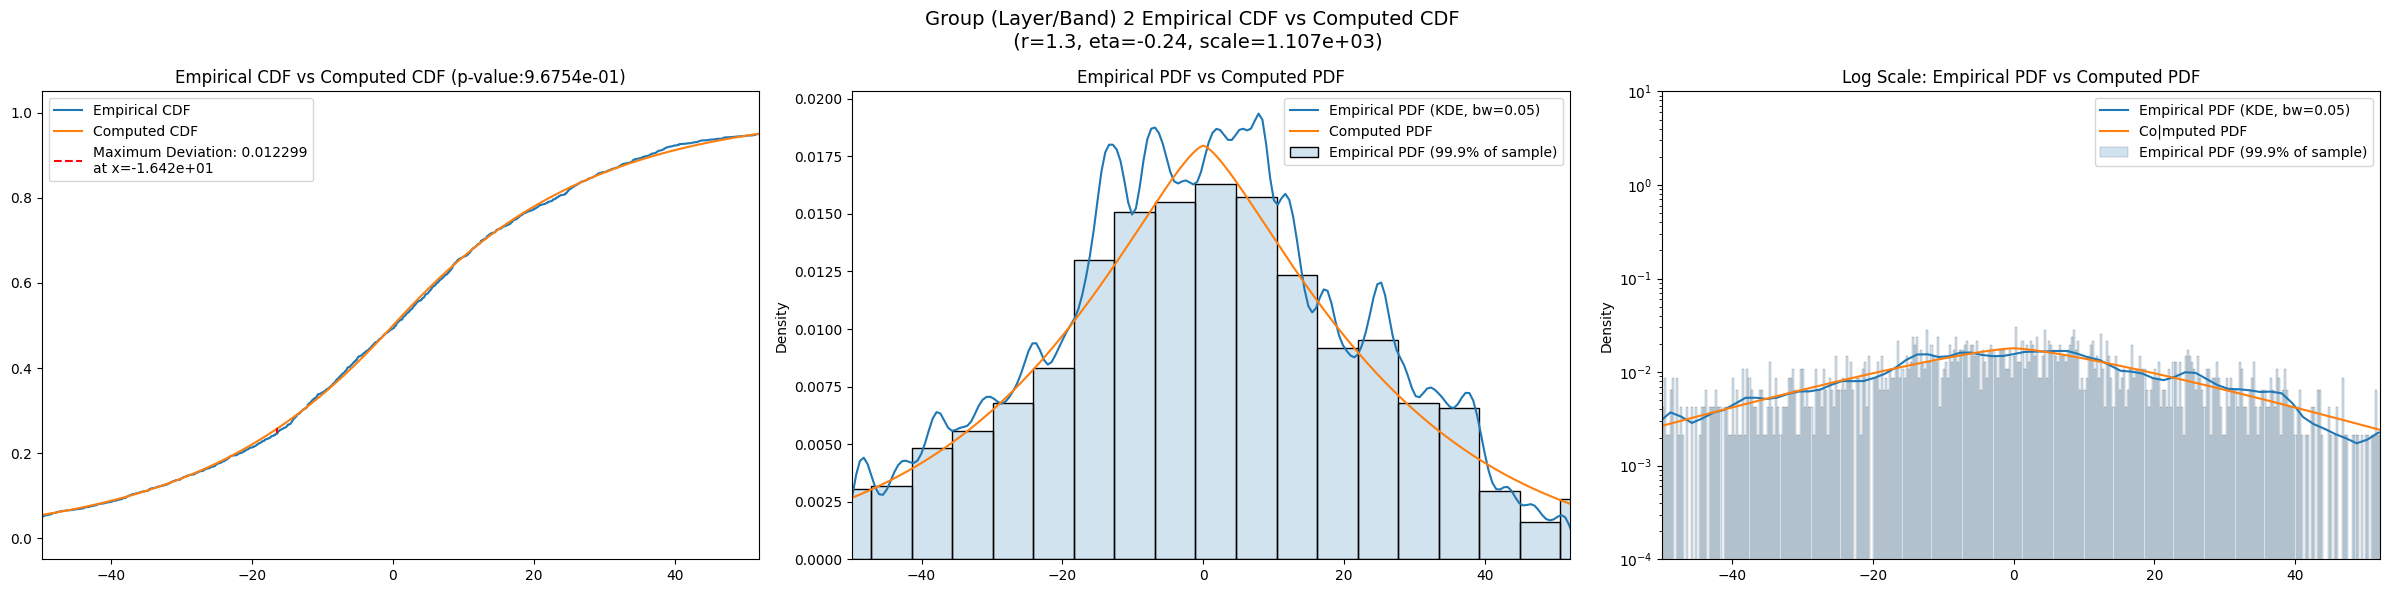

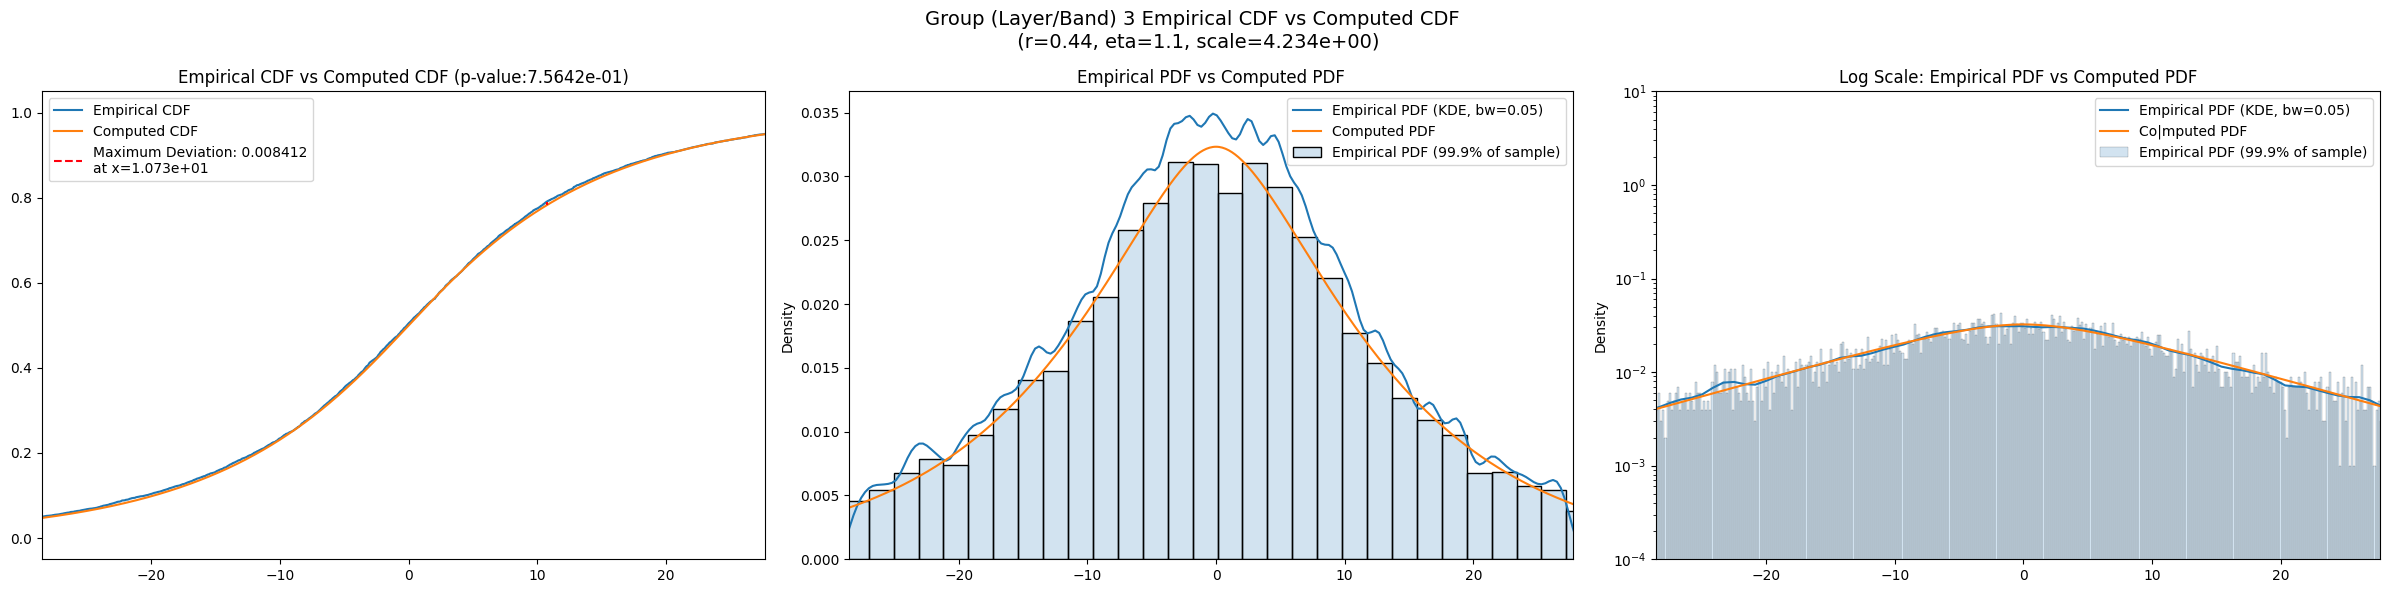

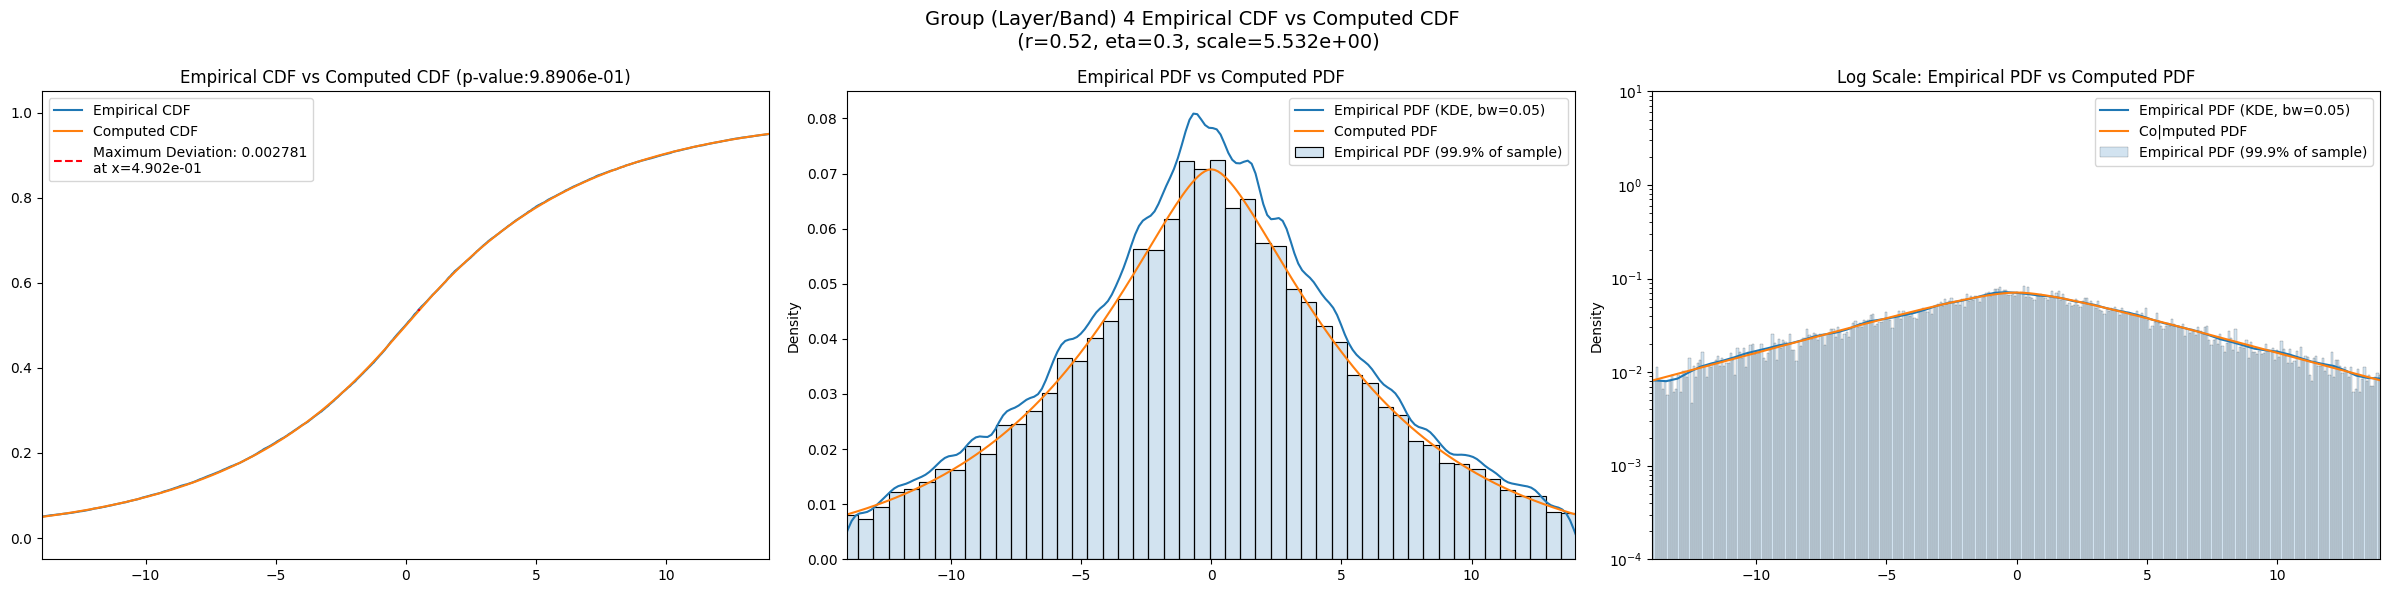

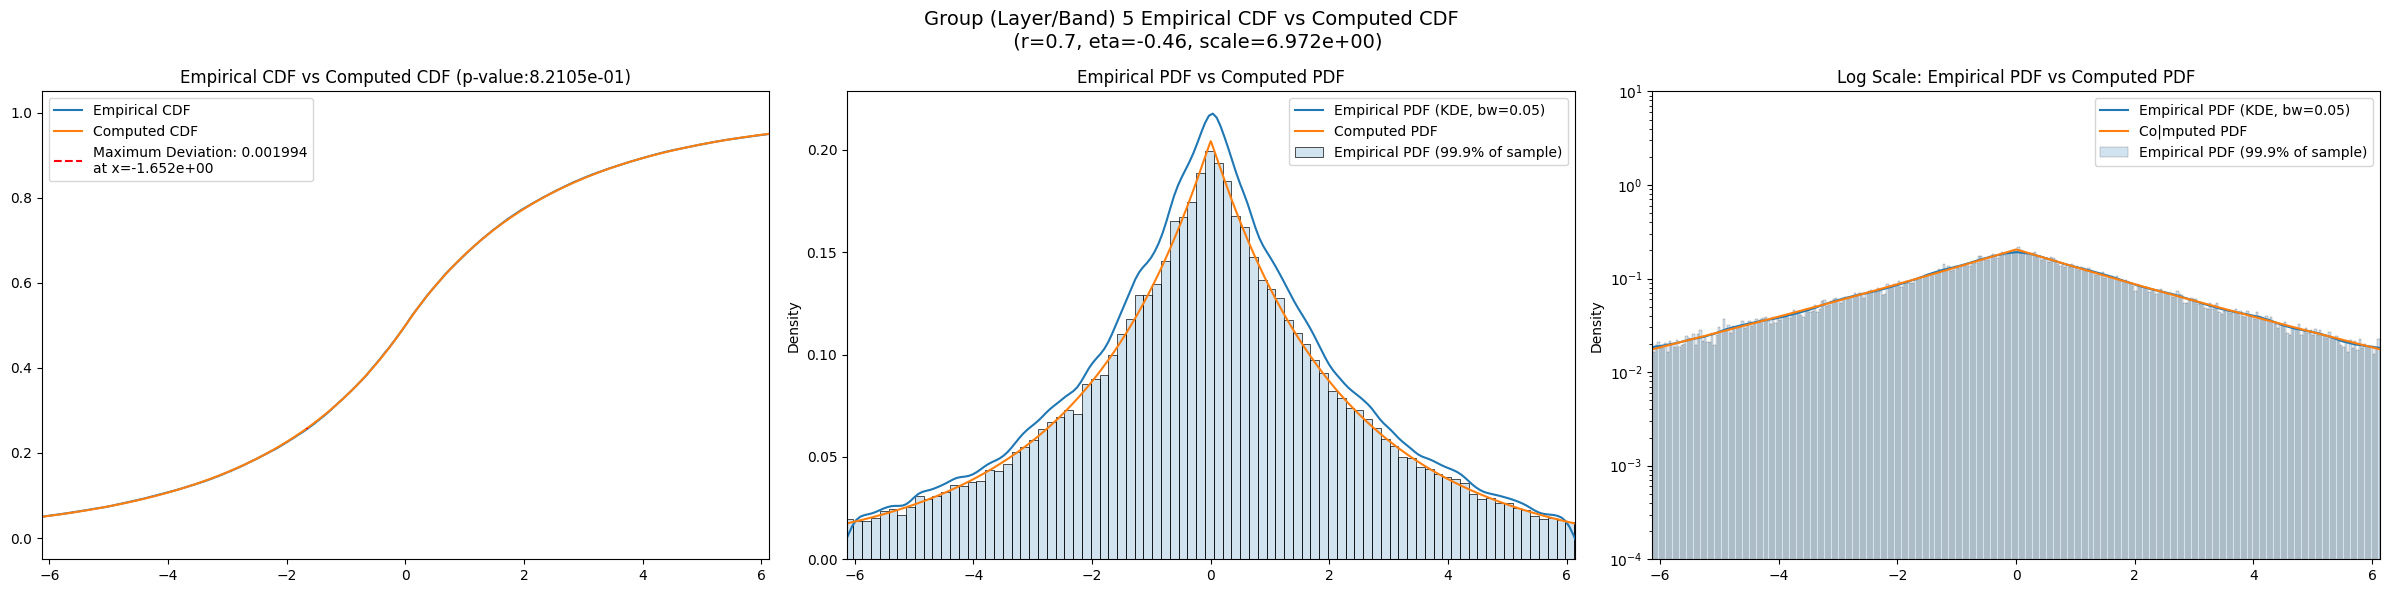

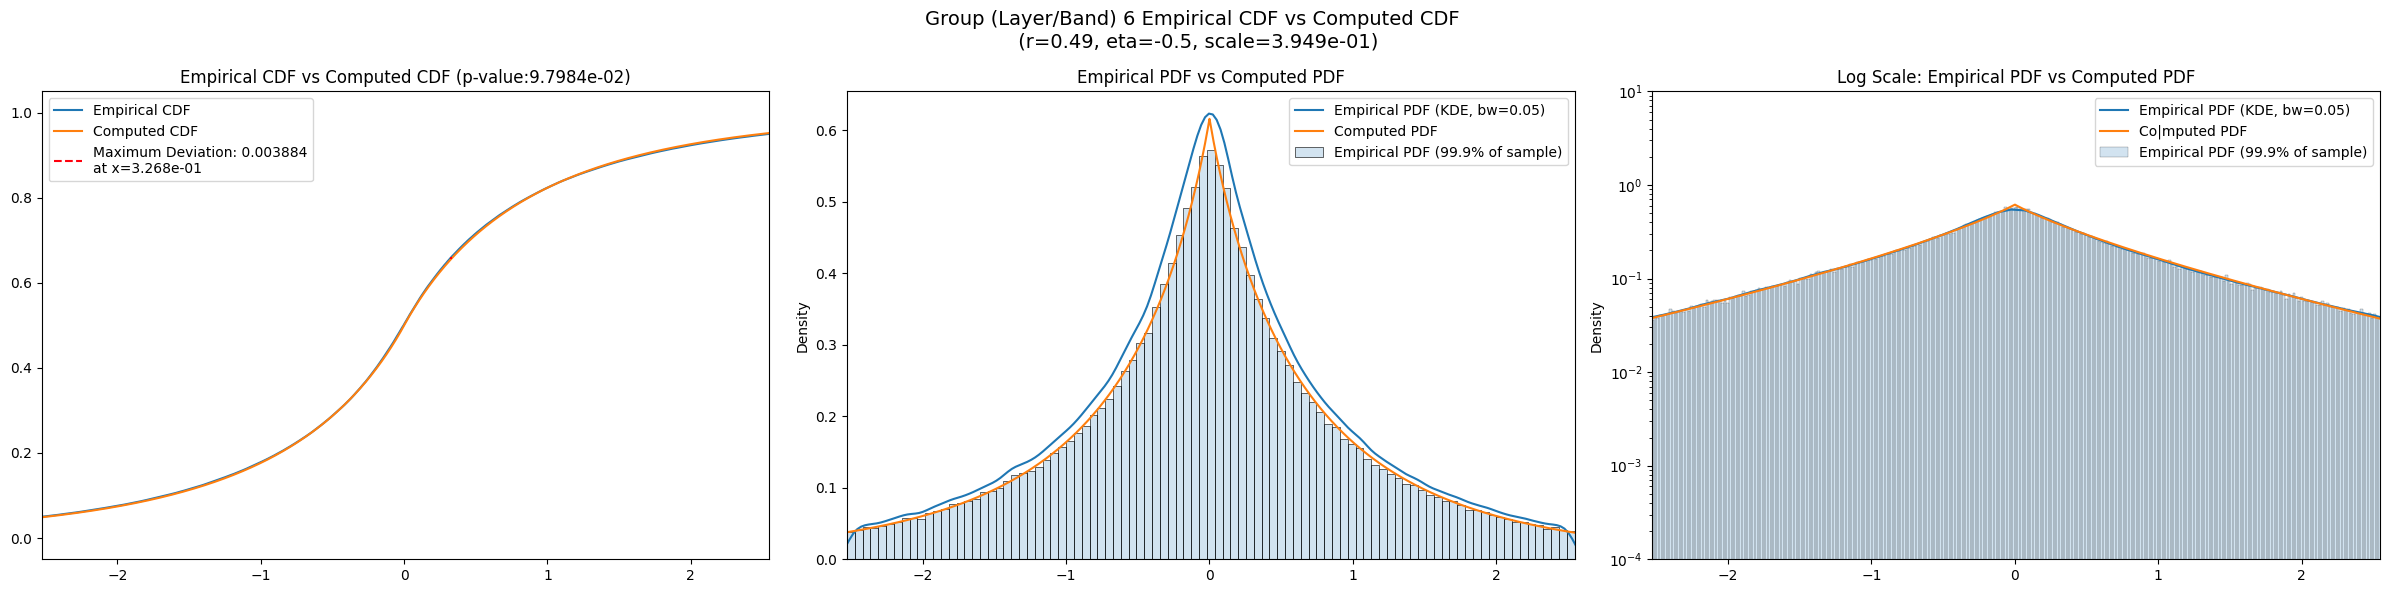

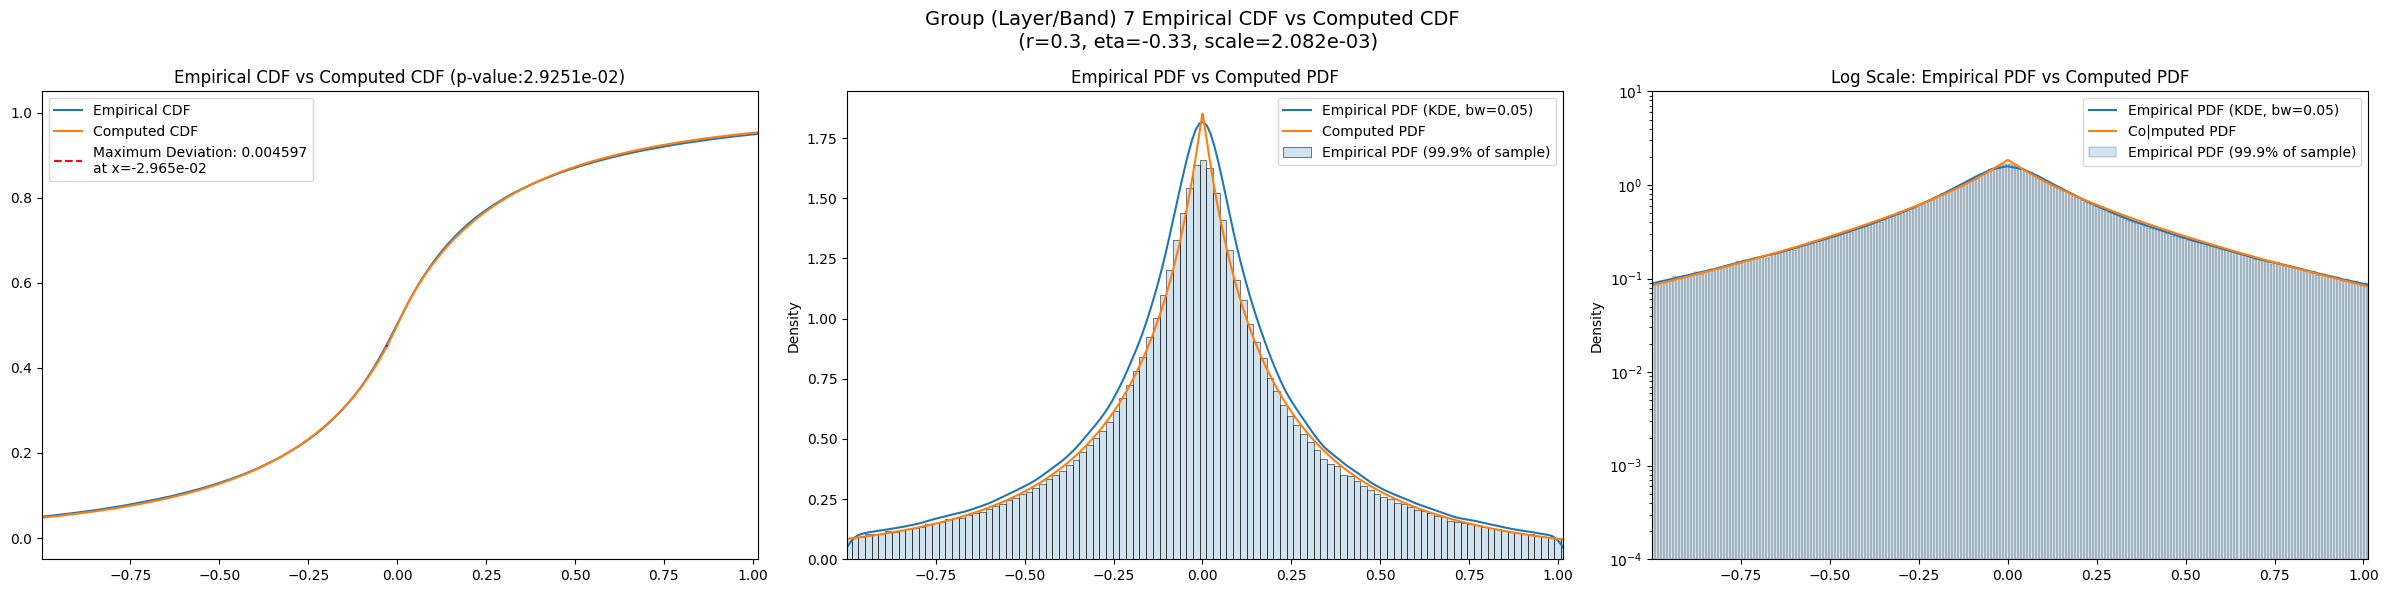

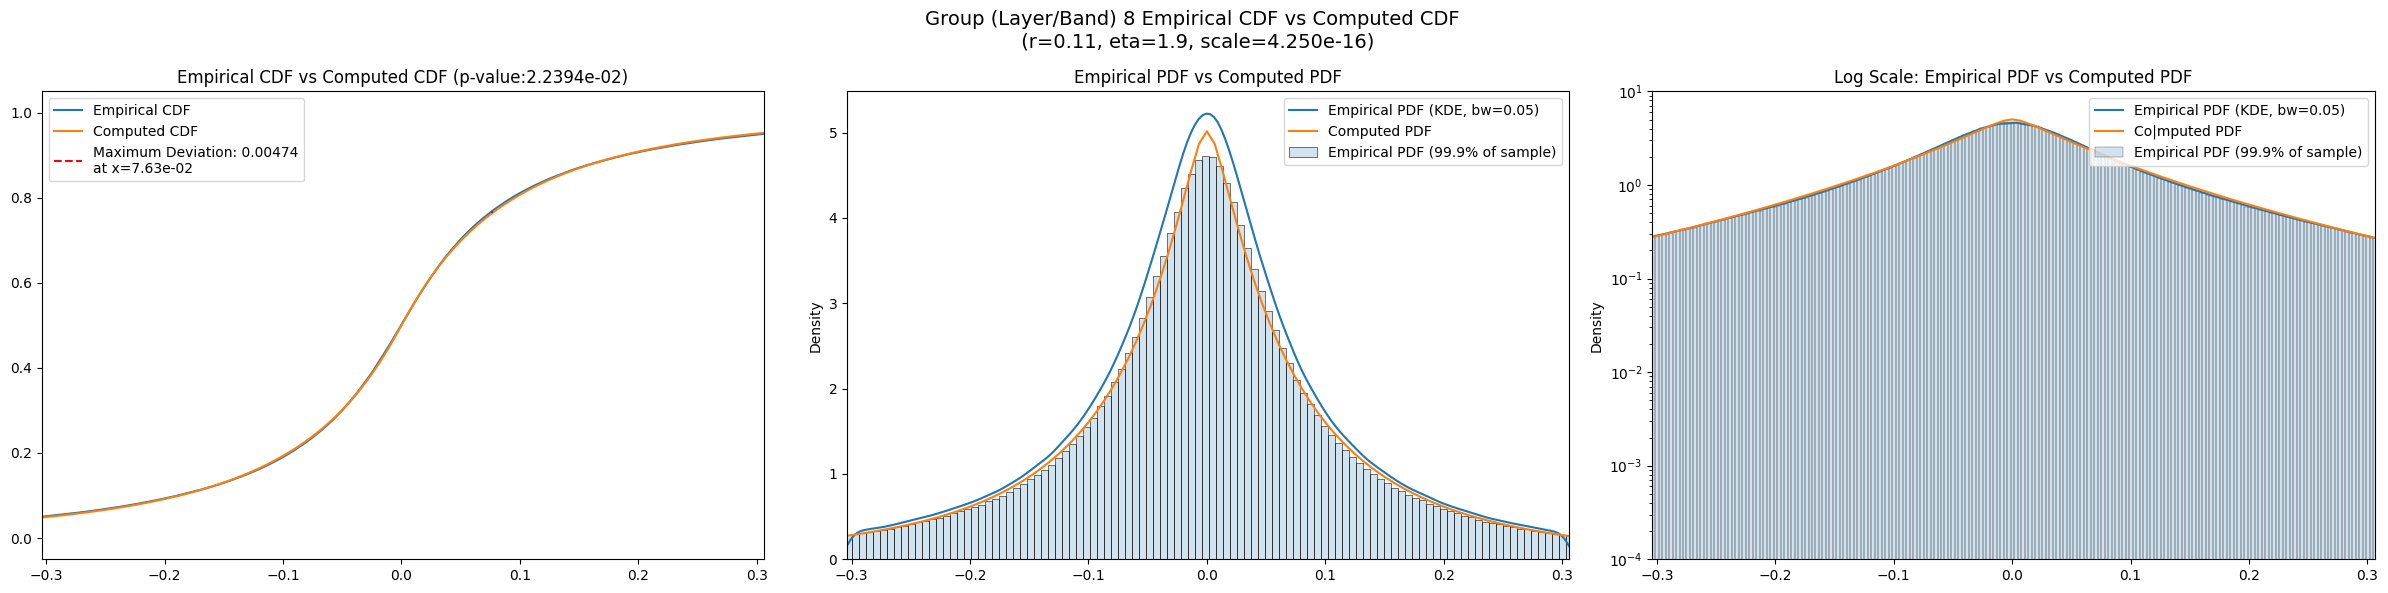

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var   var_lower    var_upper   obs_kurt  kurt_lower  kurt_upper  \
layer                                                                           
2      995.566040  864.354500  1142.784500   2.687830    1.028233    4.575933   
3      299.988920  279.984800   320.884950   2.454340    1.804920    3.180163   
4       75.562880   71.306270    80.026050   2.987251    2.351555    3.896905   
5       14.565750   13.678300    15.491117   3.872311    3.021069    4.954880   
6        2.581126    2.403492     2.771678   5.708778    4.301481    8.222433   
7        0.439725    0.403006     0.480876   9.534605    6.583607   17.606100   
8        0.044586    0.040037     0.050722  18.418106    8.617492   67.336680   

       total_samples  kstest_stat_initial  initial_r  initial_eta  ...  \
layer                                                              ...   
2               1590             0.012170        1.4         -0.3  ...   
3               6360             0.008432        0.5          0.8  ...   
4              25440             0.002853        0.6          0.1  ...   
5             101760             0.002603        0.8         -0.5  ...   
6             407040             0.004151        0.5         -0.5  ...   
7            1628160             0.005992        0.3         -0.3  ...   
8            6512640             0.004613        0.1          2.2  ...   

       param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer                                                               
2           26.898500              0.025768          2.376030e-01   
3           14.609100              0.025789          4.161510e-04   
4            7.109990              0.026376          8.295240e-16   
5            2.930290              0.032972          1.503280e-96   
6            1.101230              0.043156          0.000000e+00   
7            0.398454              0.050938          0.000000e+00   
8            0.125055              0.046367          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          24.204900             0.018609         6.336020e-01  19.849900   
3          13.205300             0.015121         1.080100e-01  10.490400   
4           6.256510             0.005810         3.556800e-01   5.087210   
5           2.556230             0.005298         6.578120e-03   2.103480   
6           0.962239             0.015347         1.042840e-83   0.780010   
7           0.349619             0.023293         0.000000e+00   0.279632   
8           0.110061             0.019546         0.000000e+00   0.088350   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.021916   4.237270e-01          9.744392e-01  
3           0.015889   7.973920e-02          7.890863e-01  
4           0.011512   2.340020e-03          9.906279e-01  
5           0.009919   3.993720e-09          9.125816e-01  
6           0.018452  8.197890e-121          1.046689e-05  
7           0.023980   0.000000e+00          7.451021e-31  
8           0.017423   0.000000e+00         3.637124e-113  

[7 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.012170                 0.033952          0.011979   
3                 0.008432                 0.017003          0.008148   
4                 0.002853                 0.008508          0.002743   
5                 0.002603                 0.004256          0.001753   
6                 0.004151                 0.002128          0.003865   
7                 0.005992                 0.001064          0.004638   
8                 0.004613                 0.000532          0.004464   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.025768             0.018609       0.021916  
3                  0.025789             0.015121       0.015889  
4                  0.026376             0.005810       0.011512  
5                  0.032972             0.005298       0.009919  
6                  0.043156             0.015347       0.018452  
7                  0.050938             0.023293       0.023980  
8                  0.046367             0.019546       0.017423

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2              995.566040          0.011979    1.30     -0.24  1.106623e+03   
3              299.988922          0.008148    0.44      1.10  4.233649e+00   
4               75.562881          0.002743    0.52      0.30  5.531722e+00   
5               14.565750          0.001753    0.70     -0.46  6.972310e+00   
6                2.581126          0.003865    0.49     -0.50  3.948604e-01   
7                0.439725          0.004638    0.30     -0.33  2.082072e-03   
8                0.044586          0.004464    0.11      1.90  4.250085e-16   

       best_exclude_cutoff  
layer                       
2                      0.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                      0.0  
7                      0.0  
8                      0.0

In [21]:
eng.quit()